<a href="https://colab.research.google.com/github/MOOwuttichai/NCDs_Listener/blob/main/C_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# เรียกใช้งานเบื้องต้น

In [1]:
# prompt: เชื่อมไดฟ์
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pythainlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 64.2 MB/s eta 0:00:00


In [3]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords

# ทำการเรียกข้อมูล

## ภาษาไทย

In [4]:
df = pd.read_excel('/content/drive/MyDrive/เชี่ยงใหม่ (1)/Copy of Data_label_All.xlsx',sheet_name=1)
df1 = pd.read_excel('/content/drive/MyDrive/เชี่ยงใหม่ (1)/Copy of Data_label_All.xlsx',sheet_name=4)
df_use0 = df[['comments','label']]
df_use1 = df1[['comments','label']]
frames = [df_use0, df_use1]
result = pd.concat(frames)
result = result.reset_index(drop=True)
Data_for_traina_and_test_thai = result

##ภาษาอังกฤษ

In [5]:
df2 = pd.read_excel('/content/drive/MyDrive/เชี่ยงใหม่ (1)/Copy of Data_label_All.xlsx',sheet_name=0)
df3 = pd.read_excel('/content/drive/MyDrive/เชี่ยงใหม่ (1)/Copy of Data_label_All.xlsx',sheet_name=2)
df_use2 = df2[['comments','label']]
df_use3 = df3[['comments','label']]
frames1 = [df_use2, df_use3]
result1 = pd.concat(frames1)
result1 = result1.reset_index(drop=True)
Data_for_traina_and_test_eng = result1

# ทำความสะอาดข้อมูล

## ภาษาไทย

In [6]:
len_count =[]
for i in range(len(Data_for_traina_and_test_thai)):
  len_count.append(len(Data_for_traina_and_test_thai['comments'][i]))
Data_for_traina_and_test_thai['len_count'] = len_count
Data_model_thai = Data_for_traina_and_test_thai[Data_for_traina_and_test_thai['len_count']>5]
labels = []
for sentiment in Data_model_thai['label']:
  if sentiment == "เล่าประสบการณ์ (tell experience)":
    labels.append(1) #เล่าประสบการณ์ (tell experience)
  elif sentiment == "คำถาม (Question)":
    labels.append(2) #ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant)
  else:
    labels.append(0)
Data_model_thai['label_num'] = labels

<ipython-input-6-fc8fc31a850c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_model_thai['label_num'] = labels


In [7]:
train_df, test_df = train_test_split(Data_model_thai, test_size=0.3, random_state=42) # 70/30 split, random_state for reproducibility
print("Training set size:", len(train_df))
print("Testing set size:", len(test_df))

Training set size: 2168
Testing set size: 930


In [8]:
train_df

,comments,label,len_count,label_num
1975,คุณป้ามะเร็งลำไส้ใหญ่ เริ่มผิดปกติมีเลือดซึมออ...,เล่าประสบการณ์ (tell experience),377,1
383,Phonpin Mongkon,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),15,0
2865,ขอแชร์นะครับ ได้รับความรู้ดีมากๆครับ,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),36,0
238,Sopa Jadurai,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),12,0
643,Somkiat Suksongkram,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),19,0
...,...,...,...,...
3131,"แม่อายุ82เป็นลมน๊อคหมดสติไป5-10นาที,จนอสม.บอกห...",เล่าประสบการณ์ (tell experience),267,1
1125,Roong N. RueangcharoenthumKong N'Wongwanich,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),43,0
1160,SiwaLee Usap เล่ามะเร็งไตของผมเป็นวิทยาทานหน่อย,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),47,0
1324,เราสามารถเข้าไปตรวจแม้จะไม่มีอาการอะไรได้ไหมคะ...,คำถาม (Question),85,2


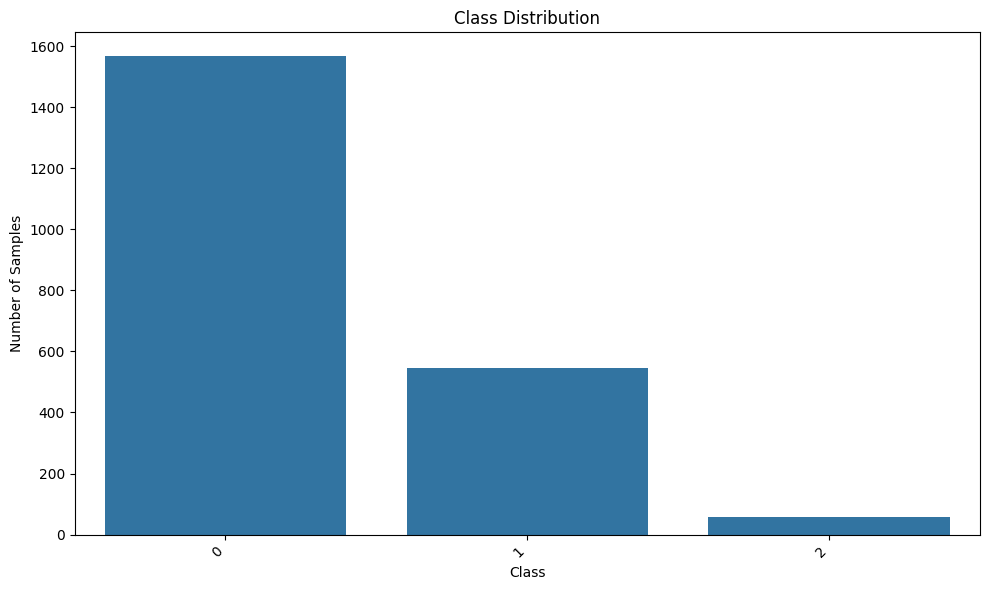

In [9]:
# Count the occurrences of each class in the 'label' column
class_counts =train_df['label_num'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

เเก้ปัญหาไม่ข้อมูลไม่บาลาน

In [10]:
# Separate features (X) and target (y)
X = train_df['comments'].values.reshape(-1, 1)  # Reshape for imblearn
y = train_df['label_num']

# Choose either oversampling or undersampling
# Oversampling:
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# # Undersampling:
# undersampler = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Create a new DataFrame with the resampled data
Data_model_thai_B = pd.DataFrame({'comments': X_resampled.flatten(), 'label': y_resampled})

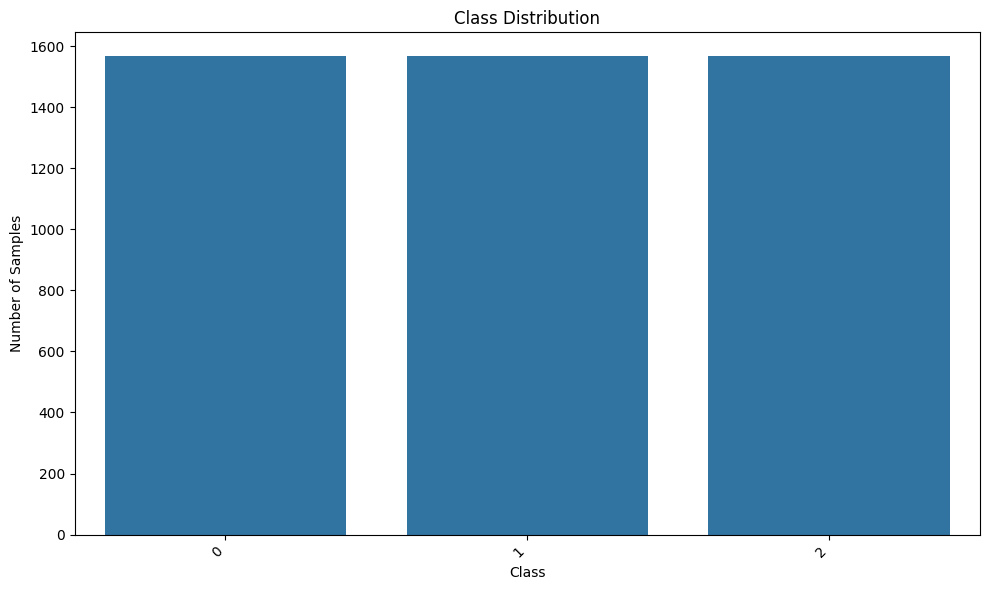

In [11]:
# Count the occurrences of each class in the 'label' column
class_counts =Data_model_thai_B['label'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

##ภาษาอังกฤษ

In [12]:
len_count =[]
for i in range(len(Data_for_traina_and_test_eng)):
  len_count.append(len(str(Data_for_traina_and_test_eng['comments'][i])))
Data_for_traina_and_test_eng['len_count'] = len_count
Data_model_eng = Data_for_traina_and_test_eng[Data_for_traina_and_test_eng['len_count']>5]
labels = []
for sentiment in Data_model_eng['label']:
  if sentiment == "เล่าประสบการณ์ (tell experience)":
    labels.append(1) #เล่าประสบการณ์ (tell experience)
  elif sentiment == "คำถาม (Question)":
    labels.append(2) #ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant)
  else:
    labels.append(0)
Data_model_eng['label_num'] = labels

<ipython-input-12-0975f7e01ad9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_model_eng['label_num'] = labels


In [13]:
train_df_E, test_df_E = train_test_split(Data_model_eng, test_size=0.3, random_state=42) # 70/30 split, random_state for reproducibility
print("Training set size:", len(train_df_E))
print("Testing set size:", len(test_df_E))

Training set size: 2454
Testing set size: 1052


In [14]:
train_df_E

,comments,label,len_count,label_num
1261,I remember her everyday. It is painful. And as...,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),187,0
801,"If you don’t want to hurt her feelings, you ca...",ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),352,0
3065,"Generally speaking, being over weight is a res...",ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),476,0
3025,How do people get addicted to cigarettes or ad...,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),439,0
3165,34/F....Former Fatty. I used to be 508lbs I am...,เล่าประสบการณ์ (tell experience),607,1
...,...,...,...,...
1095,Thanks so much for this. What did the doctor s...,คำถาม (Question),244,2
1130,Tbh I didn’t tell most people this time? Told ...,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),229,0
1294,“I didn’t buy tickets to this show and I’m not...,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),175,0
860,"2024 53F ,1 child (30M) , living with partner ...",เล่าประสบการณ์ (tell experience),332,1


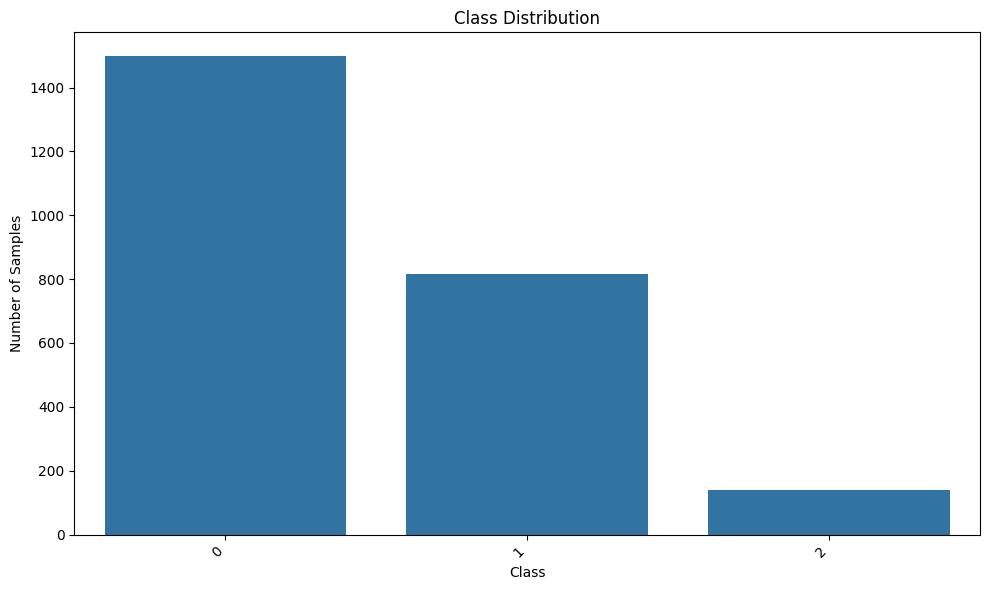

In [15]:
# Count the occurrences of each class in the 'label' column
class_counts =train_df_E['label_num'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [16]:
# Separate features (X) and target (y)
X = train_df_E['comments'].values.reshape(-1, 1)  # Reshape for imblearn
y = train_df_E['label_num']

# Choose either oversampling or undersampling
# Oversampling:
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# # Undersampling:
# undersampler = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Create a new DataFrame with the resampled data
Data_model_eng_B = pd.DataFrame({'comments': X_resampled.flatten(), 'label': y_resampled})

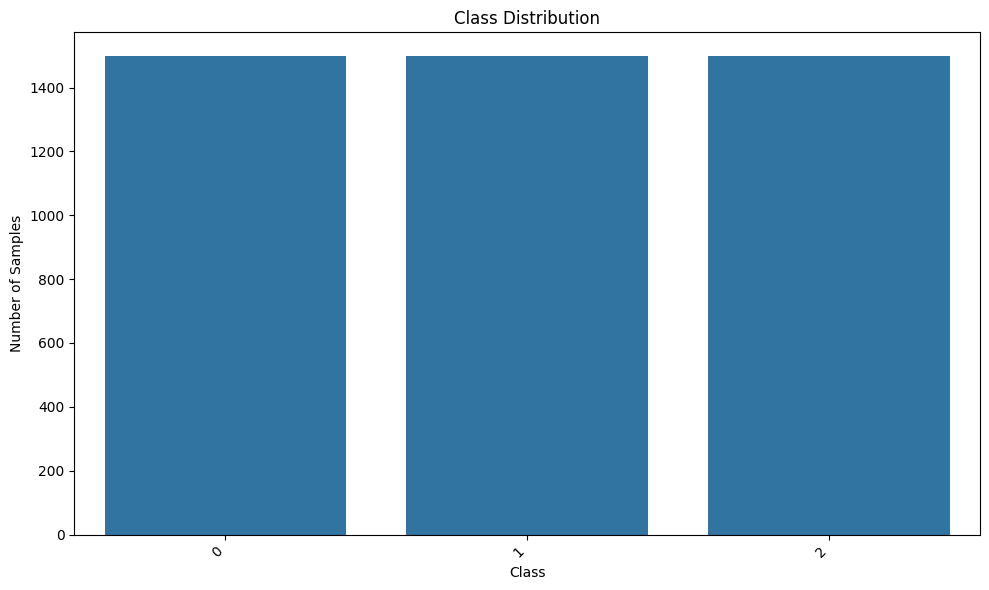

In [17]:
# Count the occurrences of each class in the 'label' column
class_counts =Data_model_eng_B['label'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [18]:
print(f'จำนวนข้อมูลภาษาอังกฤษ {len(Data_model_eng_B)}')
print(f'จำนวนข้อมูลภาษาไทย {len(Data_model_thai_B)}')

จำนวนข้อมูลภาษาอังกฤษ 4494
จำนวนข้อมูลภาษาไทย 4701


#ฝึกฝนตัวแบบ ทั้งหมด 4 ตัว

##1.support vector machine (SVM)

### ภาษาไทย

###ภาษาอังกฤษ

In [19]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Separate features (X) and target (y)
X = train_df_E['comments'].values.reshape(-1, 1)  # Reshape for imblearn
y = train_df_E['label']

# Choose either oversampling or undersampling
# Oversampling:
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# # Undersampling:
# undersampler = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Create a new DataFrame with the resampled data
Data_model_eng_B_svm = pd.DataFrame({'comments': X_resampled.flatten(), 'label': y_resampled})
Data_model_eng_B_svm

,comments,label
0,I remember her everyday. It is painful. And as...,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant)
1,"If you don’t want to hurt her feelings, you ca...",ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant)
2,"Generally speaking, being over weight is a res...",ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant)
3,How do people get addicted to cigarettes or ad...,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant)
4,34/F....Former Fatty. I used to be 508lbs I am...,เล่าประสบการณ์ (tell experience)
...,...,...
4489,"21F currently, coming up on 16 years post Epen...",เล่าประสบการณ์ (tell experience)
4490,I’ve had upper lobes in both of my lungs they ...,เล่าประสบการณ์ (tell experience)
4491,[I’m 380 pounds 23F] and honestly I’ve been fa...,เล่าประสบการณ์ (tell experience)
4492,My friend had an eating disorder. She would bi...,เล่าประสบการณ์ (tell experience)


In [21]:
test_df_E_SVM = test_df_E[['comments','label']]

In [22]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english')) # This is your set of stopwords
wnl = WordNetLemmatizer()
def text_process(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":", "!", '"', "#", "*","-",",","[","]","'",'’'))
    final = word_tokenize(final)
    final = " ".join(word for word in final)
    final = " ".join(word for word in final.split()
                     if word.lower() not in stop_words) # Use stop_words here instead of stopwords
    final = final.lower()
    final = wnl.lemmatize(final)
    # final = list(final.split(' '))
    return final

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [23]:
Train_X = Data_model_eng_B_svm['comments'].apply(text_process)
Train_Y = Data_model_eng_B_svm['label']
Test_X = test_df_E_SVM['comments'].apply(text_process)
Test_Y = test_df_E_SVM['label']
Data_model_eng_svm = Data_model_eng
Data_model_eng_svm['text_final'] = Data_model_eng_svm['comments'].apply(text_process)

<ipython-input-23-4f51ba0ed6c2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_model_eng_svm['text_final'] = Data_model_eng_svm['comments'].apply(text_process)


In [24]:
Encoder = LabelEncoder()
Train_y = Encoder.fit_transform(Train_Y)
Test_y = Encoder.fit_transform(Test_Y)

In [25]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Data_model_eng_svm['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

print(Tfidf_vect.vocabulary_)

{'hello': 2113, 'diagnosed': 1318, 'stage': 4172, 'iv': 2414, 'large': 2507, 'cell': 837, 'lymphoma': 2668, 'end': 1535, '2019': 57, 'given': 1942, 'best': 582, 'prognosis': 3445, '50': 145, 'make': 2685, 'years': 4976, 'treatment': 4600, 'went': 4866, 'stem': 4207, 'transplant': 4585, 'still': 4219, 'four': 1846, 'plus': 3316, 'almost': 327, 'five': 1789, 'since': 4012, 'diagnosis': 1320, 'year': 4974, 'long': 2627, 'post': 3347, 'details': 1304, 'happened': 2057, 'want': 4815, 'read': 3562, 'though': 4496, 'ill': 2244, 'kind': 2478, 'hit': 2140, 'ten': 4442, 'months': 2865, 'unexplained': 4682, 'itch': 2406, 'body': 644, 'excruciating': 1620, 'back': 497, 'pains': 3159, 'doctor': 1402, 'continuously': 1085, 'told': 4545, 'dramatic': 1427, 'imagining': 2253, 'things': 4486, 'house': 2186, 'dirty': 1354, 'dogs': 1406, 'anything': 381, 'actual': 235, 'work': 4928, 'woke': 4917, 'one': 3076, 'morning': 2871, 'completely': 1017, 'paralyzed': 3175, 'waist': 4803, 'checked': 869, 'emergency

In [26]:
print(Train_X_Tfidf)

  (0, 333)	0.14726549884666437
  (0, 571)	0.23589488268730974
  (0, 652)	0.30743981051376207
  (0, 666)	0.32522153881750493
  (0, 1228)	0.23832727514408086
  (0, 1596)	0.26927805728302134
  (0, 2008)	0.32178195743808863
  (0, 2037)	0.32178195743808863
  (0, 2114)	0.17210099520714608
  (0, 2415)	0.1627918856809647
  (0, 2809)	0.2145076688376667
  (0, 3157)	0.28400817625111996
  (0, 3670)	0.24357993473009187
  (0, 3944)	0.27045115037215034
  (0, 4473)	0.26591582914801504
  (1, 233)	0.25988943088356753
  (1, 381)	0.14722911899131266
  (1, 435)	0.2156159043057548
  (1, 685)	0.216613216014039
  (1, 853)	0.16949085502730052
  (1, 1410)	0.1040107905515312
  (1, 1510)	0.17541072774064317
  (1, 1585)	0.16251300000783678
  (1, 1698)	0.14098370972377508
  (1, 1736)	0.38492396685491287
  :	:
  (4493, 985)	0.18718656075230283
  (4493, 1111)	0.20057268890739502
  (4493, 1485)	0.12136528780690252
  (4493, 1535)	0.16129905580972162
  (4493, 1771)	0.14966468749211825
  (4493, 1824)	0.11315782543914836


In [ ]:
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
param_grid = dict(
    C=range(1, 50),
    kernel=['linear', 'poly', 'rbf', 'sigmoid'],
    degree=range(3,10),
    gamma=['scale', 'auto']
)
clf = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=10)
clf.fit(Train_X_Tfidf, Train_Y)
print(clf.best_params_)

In [108]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  77.75665399239544


In [109]:
print(classification_report(Test_Y,predictions_SVM))

                                              precision    recall  f1-score   support

                            คำถาม (Question)       0.25      0.13      0.17        52
            เล่าประสบการณ์ (tell experience)       0.75      0.76      0.75       367
ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant)       0.82      0.84      0.83       633

                                    accuracy                           0.78      1052
                                   macro avg       0.61      0.58      0.59      1052
                                weighted avg       0.77      0.78      0.77      1052



## 2.logistics regression(LR)

### ภาษาไทย

#### แบ่ง train/test

In [ ]:
# Assuming 'Data_model' is your DataFrame
# train_df, test_df = train_test_split(Data_model_thai_B, test_size=0.3, random_state=42) # 70/30 split, random_state for reproducibility
# print("Training set size:", len(train_df))
# print("Testing set size:", len(test_df))

Training set size: 4739
Testing set size: 2032


In [ ]:
def text_process(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":", "!", '"', "ๆ", "ฯ","-"))
    final = word_tokenize(final)
    final = " ".join(word for word in final)
    final = " ".join(word for word in final.split()
                     if word.lower not in thai_stopwords())
    # final = list(final.split(' '))
    return final
train_df['text_tokens'] = train_df['comments'].apply(text_process)
test_df['text_tokens'] = test_df['comments'].apply(text_process)

In [ ]:
X_train = train_df[['comments', 'text_tokens']]
y_train = train_df['label']
X_test = test_df[['comments', 'text_tokens'] ] # Changed from X_train to X_test
y_test = test_df['label']  # Changed from y_train to y_test

#### Word Vectorizer และ Bag-of-Words (BoW)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(analyzer=lambda x:x.split(' '))
cvec.fit_transform(X_train['text_tokens'])
cvec.vocabulary_

{'คุณป้า': 3003,
 'มะเร็ง': 4465,
 'ลำไส้ใหญ่': 4864,
 'เริ่ม': 6081,
 'ผิดปกติ': 4219,
 'มี': 4504,
 'เลือด': 6126,
 'ซึม': 3288,
 'ออกมา': 5495,
 'ทาง': 3664,
 'ทวารหนัก': 3626,
 'แต่': 6337,
 'ไป': 6694,
 'คิด': 2981,
 'ว่า': 5014,
 'คง': 2822,
 'เป็น': 5933,
 'จาก': 3103,
 'การ': 2597,
 'ถ่าย': 3605,
 'ท้อง': 3767,
 'เลย': 6108,
 'เป็นแผล': 5973,
 'หรือ': 5339,
 'ริดสีดวง': 4764,
 'ต่อมา': 3544,
 'ไหล': 6733,
 'เยอะ': 6060,
 'ขึ้น': 2788,
 'ตัว': 3456,
 'ซีด': 3282,
 'เหลือง': 6221,
 'ตรวจ': 3407,
 'เจอ': 5752,
 'ระยะ': 4709,
 '3': 140,
 'ลาม': 4855,
 'ต่อ': 3537,
 'น้ำเหลือง': 3953,
 'ฉายแสง': 3165,
 'ซูบผอม': 3293,
 'เบื่ออาหาร': 5909,
 'คน': 2828,
 'เอา': 6248,
 'ยาลูกกลอน': 4610,
 'มา': 4481,
 'ให้': 6641,
 'ป้า': 4186,
 'ทาน': 3675,
 'หลัง': 5354,
 'อาการ': 5526,
 'ดีขึ้น': 3343,
 'ทานอาหาร': 3677,
 'ได้': 6678,
 'ผิว': 4223,
 'ชมพู': 3182,
 'เนื้อหนัง': 5886,
 'แก': 6289,
 'เรื่อย': 6094,
 'ห้าม': 5432,
 'แล้วก็': 6448,
 'ไม่': 6709,
 'เชื่อ': 5783,
 'Phonpin': 1529,
 'Mongko

#### เริ่มฝึกเเละสร้างโมเดล

In [ ]:
train_bow = cvec.transform(X_train['text_tokens'])
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_bow, y_train)

LogisticRegression()

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
test_bow = cvec.transform(X_test['text_tokens'])
test_predictions = lr.predict(test_bow)
Model_Evaluation_LOG=classification_report(test_predictions, y_test)

In [ ]:
print(Model_Evaluation_LOG)

                                              precision    recall  f1-score   support

                            คำถาม (Question)       0.31      0.57      0.40        14
            เล่าประสบการณ์ (tell experience)       0.86      0.93      0.89       200
ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant)       0.98      0.94      0.96       716

                                    accuracy                           0.93       930
                                   macro avg       0.72      0.81      0.75       930
                                weighted avg       0.94      0.93      0.94       930



###ภาษาอังกฤษ

#### แบ่ง train/test

In [ ]:
# # Assuming 'Data_model' is your DataFrame
# train_df, test_df = train_test_split(Data_model_eng_B, test_size=0.3, random_state=42) # 70/30 split, random_state for reproducibility
# print("Training set size:", len(train_df))
# print("Testing set size:", len(test_df))

Training set size: 4475
Testing set size: 1918


In [ ]:
# prompt: เรียกใช้งาน stopwords ภาษาอังกฤษ

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english')) # This is your set of stopwords
wnl = WordNetLemmatizer()
def text_process(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":", "!", '"', "#", "*","-"))
    final = word_tokenize(final)
    final = " ".join(word for word in final)
    final = " ".join(word for word in final.split()
                     if word.lower() not in stop_words) # Use stop_words here instead of stopwords
    final = lower(final)
    final = wnl.lemmatize(final)
    # final = list(final.split(' '))
    return final

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
train_df_E['text_tokens'] = train_df_E['comments'].apply(text_process)
test_df_E['text_tokens'] = test_df_E['comments'].apply(text_process)
X_train = train_df_E[['comments', 'text_tokens']]
y_train = train_df_E['label']
X_test = test_df_E[['comments', 'text_tokens'] ] # Changed from X_train to X_test
y_test = test_df_E['label']

In [81]:
train_df_E

,comments,label,len_count,label_num
1261,I remember her everyday. It is painful. And as...,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),187,0
801,"If you don’t want to hurt her feelings, you ca...",ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),352,0
3065,"Generally speaking, being over weight is a res...",ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),476,0
3025,How do people get addicted to cigarettes or ad...,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),439,0
3165,34/F....Former Fatty. I used to be 508lbs I am...,เล่าประสบการณ์ (tell experience),607,1
...,...,...,...,...
1095,Thanks so much for this. What did the doctor s...,คำถาม (Question),244,2
1130,Tbh I didn’t tell most people this time? Told ...,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),229,0
1294,“I didn’t buy tickets to this show and I’m not...,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),175,0
860,"2024 53F ,1 child (30M) , living with partner ...",เล่าประสบการณ์ (tell experience),332,1


#### Word Vectorizer และ Bag-of-Words (BoW)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(analyzer=lambda x:x.split(' '))
cvec.fit_transform(X_train['text_tokens'])
cvec.vocabulary_

{'remember': 9874,
 'everyday': 5794,
 'painful': 8844,
 'therapist': 11407,
 'also': 3250,
 'believe': 3730,
 'afterlife': 3174,
 '’': 12439,
 'bought': 3928,
 'books': 3901,
 'might': 8156,
 'help': 6771,
 'deal': 4996,
 'grief': 6571,
 'share': 10415,
 'guys': 6629,
 'want': 12093,
 'hurt': 7001,
 'feelings': 6050,
 ',': 41,
 'say': 10211,
 'look': 7810,
 'later': 7602,
 'right': 10058,
 'need': 8413,
 'please': 9164,
 'talk': 11272,
 'anything': 3353,
 'else': 5606,
 'distract': 5361,
 'break': 3962,
 'change': 4284,
 'subject': 11052,
 'asking': 3462,
 'family': 5979,
 'activities': 3061,
 'etc': 5771,
 'Hopefully': 1608,
 'support': 11138,
 'respecting': 9973,
 'needs': 8417,
 'Generally': 1468,
 'speaking': 10763,
 'weight': 12167,
 'result': 10002,
 'poor': 9208,
 'diet': 5216,
 'meeting': 8060,
 'health': 6729,
 "'s": 28,
 'get': 6443,
 'regular': 9808,
 "'m": 19,
 'fat': 6002,
 'still': 10942,
 'able': 2983,
 'live': 7768,
 'levels': 7685,
 'obesity': 8581,
 'Throw': 2726,
 '

#### เริ่มฝึกเเละสร้างโมเดล

In [ ]:
train_bow = cvec.transform(X_train['text_tokens'])
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_bow, y_train)
from sklearn.metrics import confusion_matrix,classification_report
test_bow = cvec.transform(X_test['text_tokens'])
test_predictions = lr.predict(test_bow)
Model_Evaluation_LOG=classification_report(test_predictions, y_test)

In [ ]:
print(Model_Evaluation_LOG)

                                              precision    recall  f1-score   support

                            คำถาม (Question)       0.10      0.25      0.14        20
            เล่าประสบการณ์ (tell experience)       0.68      0.76      0.72       326
ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant)       0.88      0.78      0.83       706

                                    accuracy                           0.77      1052
                                   macro avg       0.55      0.60      0.56      1052
                                weighted avg       0.80      0.77      0.78      1052



## 3.Bidirectional encoder representations from transformers (BERT)

### ภาษาไทย

In [ ]:
texts = Data_model_thai_B['comments'].tolist()
labels = Data_model_thai_B['label'].tolist()

###ภาษาอังกฤษ

## 4.Long Short-Term Memory (LSTM)

### ภาษาไทย

###ภาษาอังกฤษ